# Basic setup
* connecting to drive
* Checking datset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/whisper_finetuning

/content/drive/MyDrive/nirekha_DL_assignment


In [ ]:
!ls /content/drive/MyDrive/whisper_finetuning/*.parquet

# Installing libraries

In [ ]:
!pip install -q datasets

In [ ]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install -q jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.6 MB/s eta 0:00:00


# Main code

100%|██████████| 5/5 [38:35<00:00, 463.06s/it]


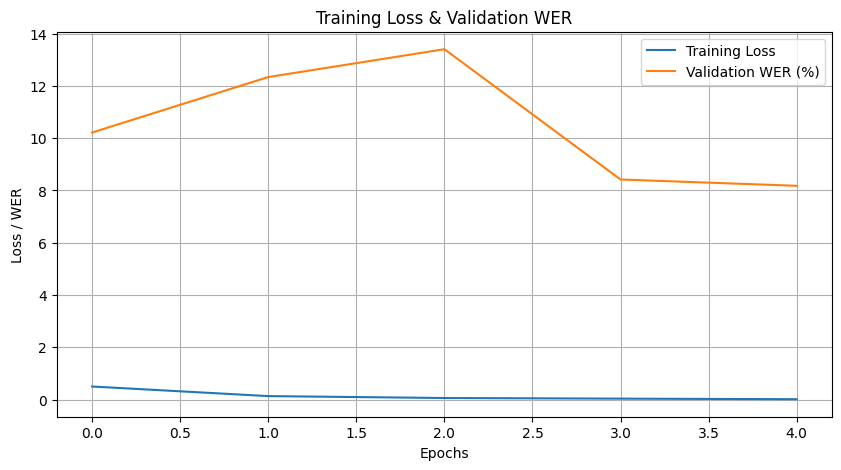

In [ ]:
# ===============================
# Step 1: Install dependencies
# ===============================
# Done in above part of code

# ===============================
# Step 2: Import libraries
# ===============================
from datasets import load_dataset, Dataset, Audio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio as IPyAudio, clear_output
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import (
    WhisperTokenizer,
    WhisperFeatureExtractor,
    WhisperForConditionalGeneration
)
import evaluate

# ===============================
# Step 3: Define helper functions
# ===============================

wer  = evaluate.load('wer')

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)
    downsampled_audio = resample(audio_original, num_samples)
    return downsampled_audio

# ===============================
# Step 4: Load Whisper components
# ===============================
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='english', task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small", language='english', task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

# ===============================
# Step 5: Load and prepare dataset
# ===============================
# Load Parquet file
df = pd.read_parquet("/content/drive/MyDrive/whisper_finetuning/train_0000.parquet")

# Convert to Hugging Face Dataset and cast 'audio' to decoded format
atco_asr_data = Dataset.from_pandas(df)
atco_asr_data = atco_asr_data.cast_column("audio", Audio(sampling_rate=16000))

# Optional: Check token lengths for text
list_of_transcription_lengths = []
for sample in atco_asr_data:
    text = sample['text']
    tokenized_text = tokenizer(text).input_ids
    list_of_transcription_lengths.append(len(tokenized_text))
plt.hist(list_of_transcription_lengths)
plt.show()

# ===============================
# Step 6: Dataset wrapper class
# ===============================
class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000, return_tensors='pt').input_features[0]
        transcription = item["text"]
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]  # remove <s>
        return {"input_features": input_features, "labels": labels}

# ===============================
# Step 7: Create dataloader
# ===============================
dataset = whisper_training_dataset(dataset=atco_asr_data, max_len=60)

train_dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
)

# ===============================
# Step 8: Evaluation function
# ===============================
def evaluation(model):
    df_val = pd.read_parquet("/content/drive/MyDrive/whisper_finetuning/valid_0000.parquet")
    atco_asr_data_val = Dataset.from_pandas(df_val)
    atco_asr_data_val = atco_asr_data_val.cast_column("audio", Audio(sampling_rate=16000))

    model.eval()
    predictions, references = [], []

    for sample in tqdm(atco_asr_data_val, total=len(atco_asr_data_val)):
        audio = down_sample_audio(sample['audio']['array'], sample['audio']['sampling_rate'])
        input_features = feature_extractor(raw_speech=audio, sampling_rate=16000, return_tensors='pt').input_features
        with torch.no_grad():
            output = model.generate(input_features.to('cuda'), language='english', task='transcribe')
        text_pred = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
        predictions.append(text_pred)
        references.append(sample['text'])

    return wer.compute(predictions=predictions, references=references) * 100

# ===============================
# Step 9: Training loop
# ===============================
device = 'cuda'
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
max_epochs = 5

running_wer = []
running_train_loss = []

for epoch in tqdm(range(max_epochs)):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    for batch in train_dataloader:
        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)
        outputs = model(input_features, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    print(f"Traing loss {avg_loss} for epoch {epoch}")
    running_train_loss.append(avg_loss)

    # Validation after each epoch
    wer_score = evaluation(model)
    print(f"Validation loss {wer_score} for epoch {epoch}")
    running_wer.append(wer_score)

    # Plot both metrics
    clear_output(wait=True)

plt.figure(figsize=(10, 5))
plt.plot(running_train_loss, label='Training Loss')
plt.plot(running_wer, label='Validation WER (%)')
plt.xlabel('Epochs')
plt.ylabel('Loss / WER')
plt.title('Training Loss & Validation WER')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# ===============================
# Save fine-tuned model
# ===============================

output_dir = "/content/drive/MyDrive/whisper_finetuning/whisper-finetuned-model"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)

print(f"Model and components saved to: {output_dir}")


# Finetuned model Testing

In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperTokenizer, WhisperFeatureExtractor

out_dir_path = '/content/drive/MyDrive/whisper_finetuning/whisper-finetuned-model'
model_finetuned = WhisperForConditionalGeneration.from_pretrained(out_dir_path).to('cuda')
tokenizer_finetuned = WhisperTokenizer.from_pretrained(out_dir_path)
feature_extractor_finetuned = WhisperFeatureExtractor.from_pretrained(out_dir_path)

In [ ]:
from datasets import Dataset, Audio
import pandas as pd
import torch

# Load validation parquet file using pandas
df_val = pd.read_parquet("/content/drive/MyDrive/whisper_finetuning/valid_0000.parquet")

# Convert to Hugging Face Dataset and decode audio column
atco_asr_data = Dataset.from_pandas(df_val)
atco_asr_data = atco_asr_data.cast_column("audio", Audio(sampling_rate=16000))

# Set model to evaluation mode
model.eval()

# Predict first 5 samples
for idx in range(5):
    sample = atco_asr_data[idx]
    target = sample['text']
    audio_original = sample['audio']['array']
    sample_rate = sample['audio']['sampling_rate']

    # Downsample and extract features
    audio_ds = down_sample_audio(audio_original, sample_rate)
    input_feature = feature_extractor_finetuned(
        raw_speech=audio_ds,
        sampling_rate=16000,
        return_tensors='pt'
    ).input_features

    # Generate prediction
    with torch.no_grad():
        output = model_finetuned.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer_finetuned.batch_decode(output, skip_special_tokens=True)[0]

    # Display result
    print(f'------- Sample {idx} -------')
    print(f'True : {target}')
    print(f'Pred : {text_pred}')
    print('\n')


`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> has been passed to `.generate()`, but it was also created in `.generate()`, given its parameterization. The custom <class 'transformers.generation.logits_process.SuppressTokensLogitsProce

------- Sample 0 -------
True : Eurowings Seven Alfa Bravo turn right heading two one zero cleared ILS approach runway two four report established heading(-ding)  two one zero cleared for the ILS two four report established Eurowings Seven Alpha Bravo 
Pred : Eurotrans Seven Alpha Bravo turn right heading two one zero cleared ILS approach runway two four report established heading two one zero cleared for the ILS two four report established Eurotrans Seven Alpha Bravo 


------- Sample 1 -------
True : Skytravel Two Eight Two Seven and there is closed echo airspace below flight level one hundred so  if you wish to avoid class echo airspace next descend in two zero miles 
Pred : Skytrail Two Eight Two Seven and there is class echo space below flight level one hundred so if you wish to avoid class echo space next descend in two zero miles 


------- Sample 2 -------
True : Oscar Kilo Papa Romeo Mike turn right heading zero six zero zero six zero right turn Oscar Papa Romeo Mike 
Pred : O

# Original model Testing

In [ ]:
from datasets import Dataset, Audio
import pandas as pd
import torch
from transformers import WhisperForConditionalGeneration, WhisperTokenizer, WhisperFeatureExtractor

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language='english', task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small", language='english', task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

# Load validation parquet file using pandas
df_val = pd.read_parquet("/content/drive/MyDrive/whisper_finetuning/valid_0000.parquet")

# Convert to Hugging Face Dataset and decode audio column
atco_asr_data = Dataset.from_pandas(df_val)
atco_asr_data = atco_asr_data.cast_column("audio", Audio(sampling_rate=16000))

# Set model to evaluation mode
model.eval()

# Predict first 5 samples
for idx in range(5):
    sample = atco_asr_data[idx]
    target = sample['text']
    audio_original = sample['audio']['array']
    sample_rate = sample['audio']['sampling_rate']

    # Downsample and extract features
    audio_ds = down_sample_audio(audio_original, sample_rate)
    input_feature = feature_extractor(
        raw_speech=audio_ds,
        sampling_rate=16000,
        return_tensors='pt'
    ).input_features

    # Generate prediction
    with torch.no_grad():
        output = model.generate(input_feature.to('cuda'), language='english', task='transcribe')

    text_pred = tokenizer.batch_decode(output, skip_special_tokens=True)[0]

    # Display result
    print(f'------- Sample {idx} -------')
    print(f'True : {target}')
    print(f'Pred : {text_pred}')
    print('\n')


------- Sample 0 -------
True : Eurowings Seven Alfa Bravo turn right heading two one zero cleared ILS approach runway two four report established heading(-ding)  two one zero cleared for the ILS two four report established Eurowings Seven Alpha Bravo 
Pred :  You are having 7A, turn right heading 210, clear dial as approach runway 24, report established. Same, 210 cleared for the ANS24, report established, you are having 7A.


------- Sample 1 -------
True : Skytravel Two Eight Two Seven and there is closed echo airspace below flight level one hundred so  if you wish to avoid class echo airspace next descend in two zero miles 
Pred :  Skydrought 227 and there is class acro space below fl 100 so if you wish to avoid class acro space next descent in a 2-0 mile.


------- Sample 2 -------
True : Oscar Kilo Papa Romeo Mike turn right heading zero six zero zero six zero right turn Oscar Papa Romeo Mike 
Pred :  Oscar kill Papa, I'm on my mic, turn right heading 060. 060, right on Oscar, Pa

# UI

In [ ]:
!pip install -q librosa

In [ ]:
import gradio as gr
import torch
from transformers import WhisperForConditionalGeneration, WhisperTokenizer, WhisperFeatureExtractor
from scipy.signal import resample
import numpy as np
import librosa

# Load fine-tuned model
finetuned_dir = '/content/drive/MyDrive/whisper_finetuning/whisper-finetuned-model'
model_finetuned = WhisperForConditionalGeneration.from_pretrained(finetuned_dir).to('cuda')
tokenizer_finetuned = WhisperTokenizer.from_pretrained(finetuned_dir)
feature_extractor_finetuned = WhisperFeatureExtractor.from_pretrained(finetuned_dir)

# Load original (base) model
model_base = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')
tokenizer_base = WhisperTokenizer.from_pretrained("openai/whisper-small", language='english', task='transcribe')
feature_extractor_base = WhisperFeatureExtractor.from_pretrained("openai/whisper-small", language='english', task='transcribe')

# Downsampling function
def down_sample_audio(audio_array, original_sr, target_sr=16000):
    num_samples = int(len(audio_array) * target_sr / original_sr)
    return resample(audio_array, num_samples)

# Transcription comparison function
def transcribe_audio_compare(audio_file):
    try:
        # Load audio using librosa
        audio_array, sr = librosa.load(audio_file, sr=None)
        audio_array = down_sample_audio(audio_array, sr)

        # Preprocess for both models
        input_features_finetuned = feature_extractor_finetuned(
            audio_array, sampling_rate=16000, return_tensors="pt"
        ).input_features.to("cuda")

        input_features_base = feature_extractor_base(
            audio_array, sampling_rate=16000, return_tensors="pt"
        ).input_features.to("cuda")

        # Predict with fine-tuned model
        with torch.no_grad():
            pred_finetuned = model_finetuned.generate(input_features_finetuned, language="english", task="transcribe")
        text_finetuned = tokenizer_finetuned.batch_decode(pred_finetuned, skip_special_tokens=True)[0]

        # Predict with base model
        with torch.no_grad():
            pred_base = model_base.generate(input_features_base, language="english", task="transcribe")
        text_base = tokenizer_base.batch_decode(pred_base, skip_special_tokens=True)[0]

        return text_finetuned, text_base

    except Exception as e:
        return f"Error: {str(e)}", f"Error: {str(e)}"


# Gradio UI
iface = gr.Interface(
    fn=transcribe_audio_compare,
    inputs=gr.Audio(type="filepath", label="Upload Audio (.wav/.mp3)"),
    outputs=[
        gr.Textbox(label="Fine-Tuned Whisper Transcription"),
        gr.Textbox(label="Original Whisper Transcription")
    ],
    title="Whisper ASR Comparison",
    description="Upload audio and compare outputs from your fine-tuned Whisper model and the original pre-trained model.",
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf66f2178353aaa07e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# To get sample auido fro validation dataset

In [ ]:
import soundfile as sf

In [ ]:
# Load the dataset
df_v = pd.read_parquet("/content/drive/MyDrive/whisper_finetuning/valid_0000.parquet")
atco_asr_data_v = Dataset.from_pandas(df_v)
atco_asr_data_v = atco_asr_data_v.cast_column("audio", Audio(sampling_rate=16000))

# Choose the sample to save (e.g., sample 0)
sample = atco_asr_data_v[0]
audio_array = sample["audio"]["array"]
sample_rate = sample["audio"]["sampling_rate"]

# Save the audio to WAV format
sf.write("sample_0.wav", audio_array, samplerate=sample_rate)

print("Saved sample_0.wav for UI testing.")

Saved sample_0.wav for UI testing.


In [ ]:
sample['text']

'Eurowings Seven Alfa Bravo turn right heading two one zero cleared ILS approach runway two four report established heading(-ding)  two one zero cleared for the ILS two four report established Eurowings Seven Alpha Bravo '